In [1]:
!nvidia-smi 

Sun Feb 27 11:06:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


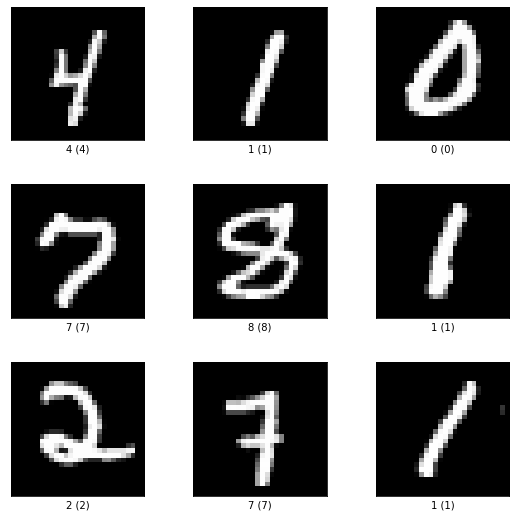

In [3]:
ds_train, ds_info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
batch_size = 400
global_batch_size = batch_size * 1
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    label = features['label']
    return image, label

ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(global_batch_size).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

150


In [5]:
class cDCGAN():
    
    def __init__(self, input_shape):
        
        self.z_dim = 100
        self.input_shape = input_shape
        self.num_classes = 10
        
        # discriminator
        self.n_discriminator = 1
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = tf.keras.optimizers.RMSprop(1e-4)
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
        # build generator with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.output, self.generator.input[1]])
        self.model = Model(self.generator.input, discriminator_output)
        self.model.compile(loss = self.bce_loss,
                           optimizer = tf.keras.optimizers.RMSprop(1e-4))
        self.discriminator.trainable = True
        #self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def conv_block(self, channels, kernels, strides=1, batchnorm=True, activation=True):
        
        model = tf.keras.Sequential()
        
        model.add(layers.Conv2D(channels, kernels, strides=strides, padding='same'))
        if batchnorm:
            model.add(layers.BatchNormalization())
        if activation:
            model.add(layers.LeakyReLU(0.2))
            
        return model
    
    def bce_loss(self, y_true, y_pred):
        
        loss = self.bce(y_true, y_pred)
        
        return loss
    
    def build_generator(self):
        
        DIM = 64
        
        input_label = layers.Input(shape=1, dtype=tf.int32, name='ClassLabel')
        
        one_hot_label = tf.one_hot(input_label, self.num_classes)
        one_hot_label = layers.Reshape((self.num_classes,))(one_hot_label)
        
        input_z = layers.Input(shape=self.z_dim, name='LatentVector')
        x = layers.Concatenate()([input_z, one_hot_label])
        x = layers.Dense(4*4*4*DIM, activation=None)(x)
        x = layers.Reshape((4,4,4*DIM))(x)
        
        x = layers.UpSampling2D((2,2), interpolation='bilinear')(x)
        x = self.conv_block(2*DIM, 5)(x)
        
        x = layers.UpSampling2D((2,2), interpolation='bilinear')(x)
        x = self.conv_block(DIM, 5)(x)
        
        x = layers.UpSampling2D((2,2), interpolation='bilinear')(x)
        output = layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')(x)
        
        return Model([input_z, input_label], output)
    
    def build_discriminator(self):
        
        DIM = 64
        
        # label
        input_label = layers.Input(shape=[1], dtype=tf.int32, name='ClassLabel')
        encoded_label = tf.one_hot(input_label, self.num_classes)
        embedding = layers.Dense(32 * 32 * 1, activation=None)(encoded_label)
        embedding = layers.Reshape((32,32,1))(embedding)
        
        # discriminator
        input_image = layers.Input(shape=self.input_shape, name='Image')
        x = layers.Concatenate()([input_image, embedding])
        x = self.conv_block(DIM, 5, 2, batchnorm=False)(x)
        x = self.conv_block(2*DIM, 5, 2)(x)
        x = self.conv_block(4*DIM, 5, 2)(x)
        x = layers.Flatten()(x)
        
        output = layers.Dense(1, activation='sigmoid')(x)
        
        return Model([input_image, input_label], output)
    
    def train_discriminator(self, real_images, class_labels, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = tf.zeros(batch_size)
        
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_class_labels = tf.random.uniform((batch_size,1), minval=0, maxval=10, dtype=tf.dtypes.int32)
        fake_images = self.generator.predict([g_input, fake_class_labels])
        
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([fake_images, fake_class_labels])
            pred_real = self.discriminator([real_images, class_labels])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)
            
            # total loss
            total_loss = 0.5*(loss_fake+loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        return loss_fake, loss_real
    
    def train(self, data_generator, batch_size, steps, interval=100):
        
        val_g_input = tf.random.normal((self.num_classes, self.z_dim))
        val_class_labels = np.arange(self.num_classes)
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
            
            real_images, class_labels = next(data_generator)
            loss_fake, loss_real = self.train_discriminator(real_images, class_labels, batch_size)
            discriminator_loss = 0.5*(loss_fake+loss_real)
            
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            fake_class_labels = tf.random.uniform((batch_size,1), minval=0, maxval=10, dtype=tf.dtypes.int32)
            
            g_loss = self.model.train_on_batch([g_input, fake_class_labels], real_labels)
            if i%interval==0:
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f}".format(i, discriminator_loss, g_loss)
                print(msg)
                
                fake_images = self.generator.predict([val_g_input, val_class_labels])
                self.plot_images(fake_images)
                
    def plot_images(self, images):
        
        grid_row = 1
        grid_col = 10
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)/2, cmap='gray')
            axarr[col].axis('off')
        plt.show()
        
    def sample_images(self, class_labels):
        z = tf.random.normal((len(class_labels), self.z_dim))
        images = self.generator.predict([z, class_labels])
        self.plot_images(images)
        return images

In [6]:
cdcgan = cDCGAN(image_shape)

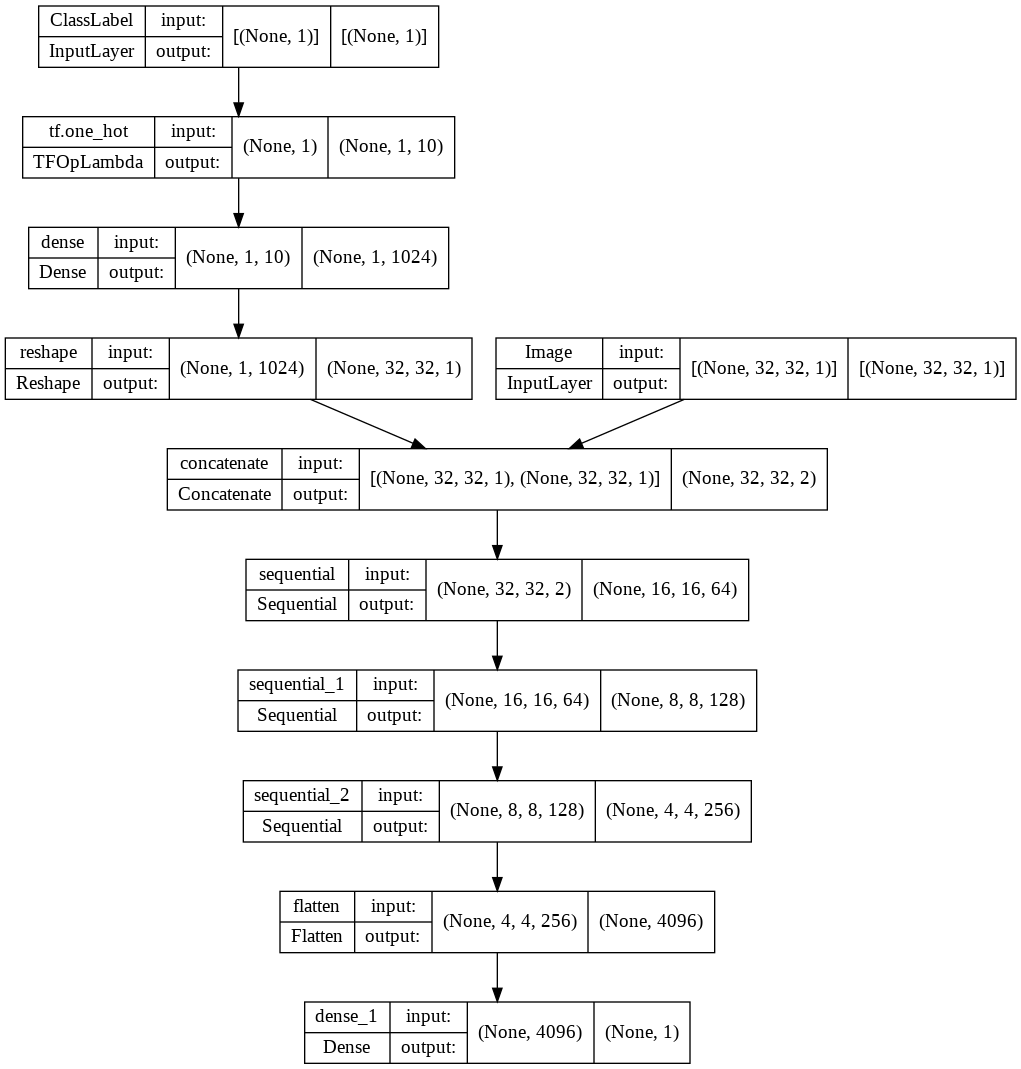

In [7]:
tf.keras.utils.plot_model(cdcgan.discriminator, show_shapes=True)

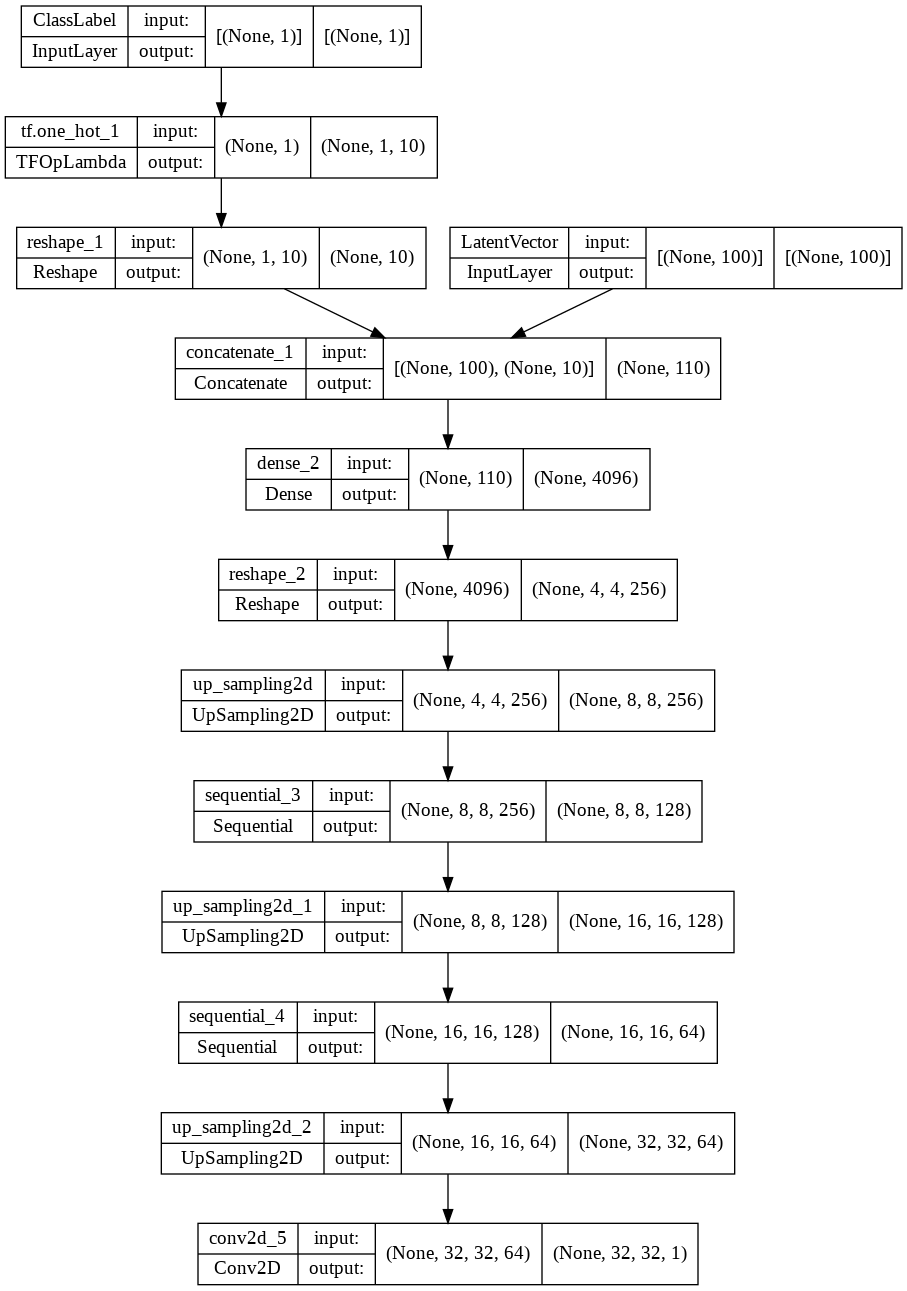

In [8]:
tf.keras.utils.plot_model(cdcgan.generator, show_shapes=True)

Step 0: discriminator_loss 0.6962 g_loss 0.6555


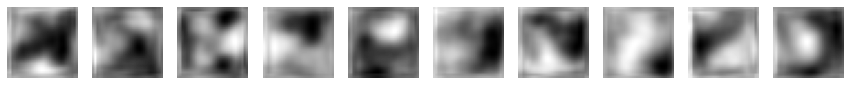

Step 200: discriminator_loss 0.0519 g_loss 0.0007


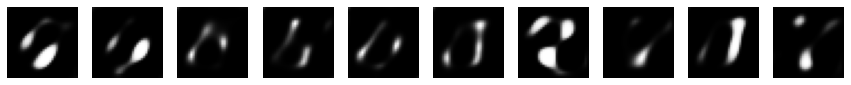

Step 400: discriminator_loss 0.4825 g_loss 0.3119


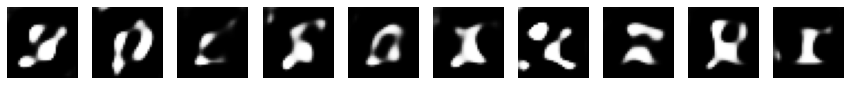

Step 600: discriminator_loss 0.5989 g_loss 1.0558


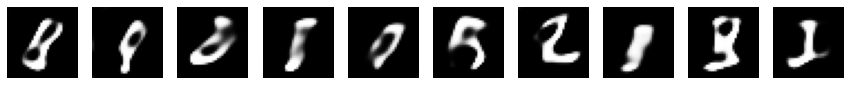

Step 800: discriminator_loss 0.6053 g_loss 0.7127


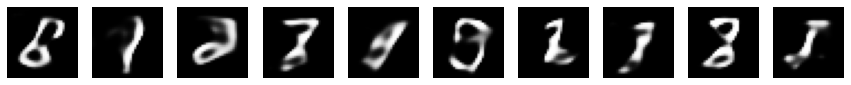

Step 1000: discriminator_loss 0.6054 g_loss 1.2083


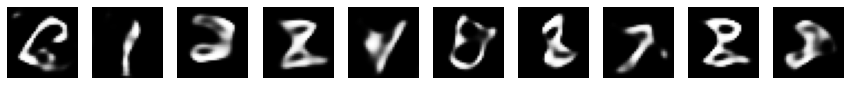

Step 1200: discriminator_loss 0.6202 g_loss 1.3114


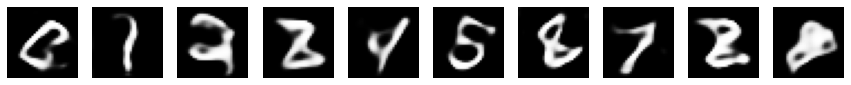

Step 1400: discriminator_loss 0.5861 g_loss 1.1438


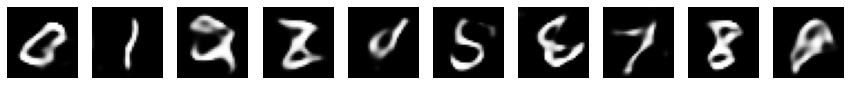

Step 1600: discriminator_loss 0.6053 g_loss 1.1758


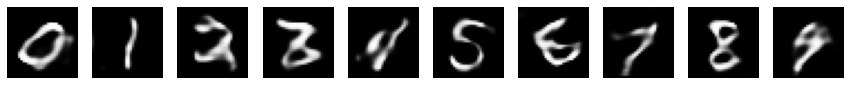

Step 1800: discriminator_loss 0.6321 g_loss 1.1859


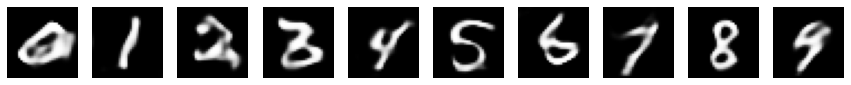

In [9]:
cdcgan.train(iter(ds_train), batch_size, 2000, 200)

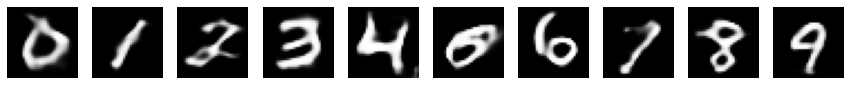

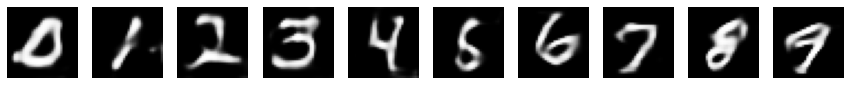

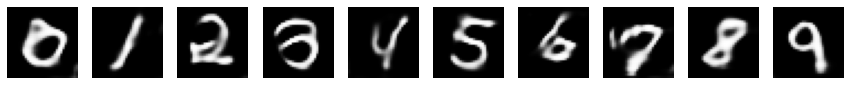

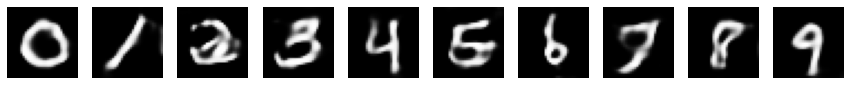

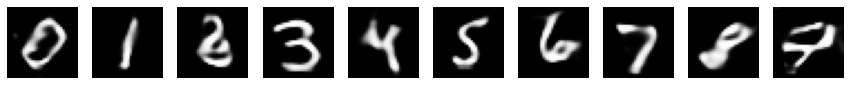

In [10]:
for i in range(5):
  images = cdcgan.sample_images(np.array([0,1,2,3,4,5,6,7,8,9]))

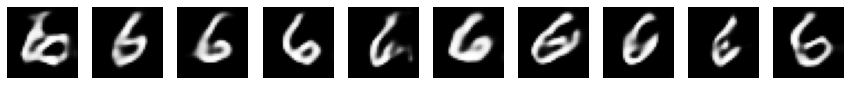

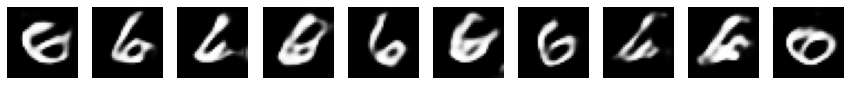

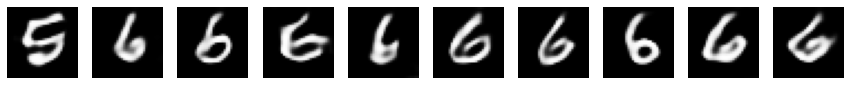

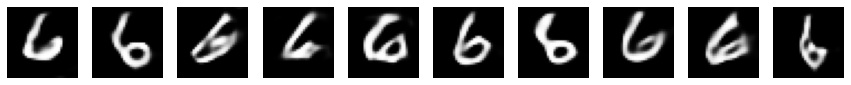

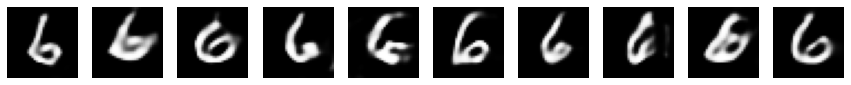

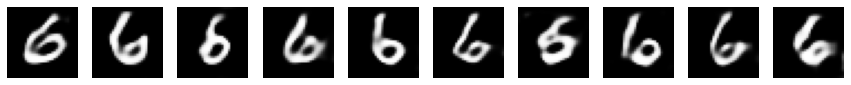

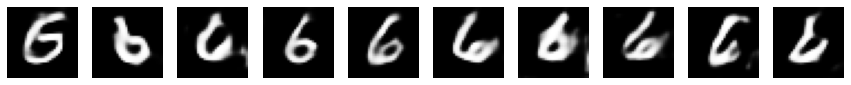

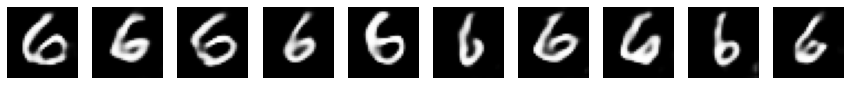

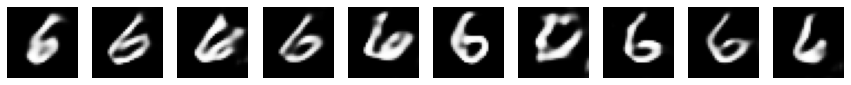

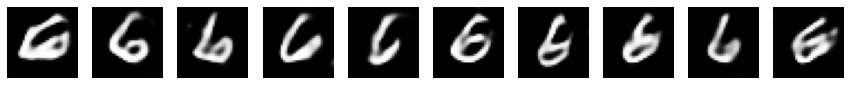

In [13]:
for i in range(10):
  images = cdcgan.sample_images(np.array([6,6,6,6,6,6,6,6,6,6]))